In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/FEM')
%load_ext autoreload

In [80]:
%autoreload 2
from FEMOL import RectangleQuadMesh, FEM_Problem, TOPOPT_Problem, PlateBendingResults
from FEMOL_materials import IsotropicMaterial
from FEMOL_utils import create_domain
import timeit
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Developping Notebook

### Mesh

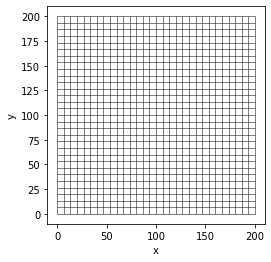

In [148]:
n = 30

nelx = n # elements in the x direction
nely = n # elements in the y direction

# Creating the mesh
Lx = 200
Ly = 200

mesh = RectangleQuadMesh(Lx, Ly, nelx, nely)
mesh.plot()

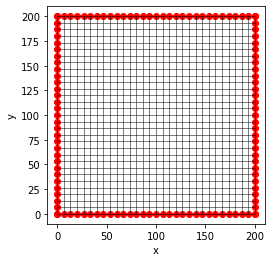

In [149]:
problem = FEM_Problem('modal', 'plate', mesh)

E = 2000000000.0 # N/mm^2
mu = 0.3
rho = 7.850 *(1 / 1000**3)  # kg/mm^3
t = 6  # mm


steel = IsotropicMaterial( E, mu, rho)
problem.define_materials(steel)

problem.define_tensors(t, 1)

x = [0, Lx]
y = [[0, Ly]]
fixed_domain1 = create_domain(x, y)
problem.add_fixed_domain(fixed_domain1, ddls=[2])

x = [[0, Lx]]
y = [0, Ly]
fixed_domain2 = create_domain(x, y)
problem.add_fixed_domain(fixed_domain2, ddls=[2])

problem.assemble('K')
problem.assemble('M')
problem.fix_boundary()

problem.plot()

In [150]:
result = problem.solve()

In [159]:
# Computed values
omegas = result[0]
vectors = result[1]

freqs = np.array([np.sqrt(freq) for freq in omegas if freq > 0])
freqs = freqs[freqs>=140]
tol = 50  # Hz
freqs = freqs[~(np.triu(np.abs(freqs[:,None] - freqs) <= tol,1)).any(0)]


# Theoretical values:
Bs = [5.70, 14.26, 22.82, 28.52, 37.08, 48.49]

E_th = 29007547.5  # Lb/in2
rho_th = 0.00088162468  
rho_th2 = 0.283599
a_th = 7.87402  # 200 mm in inches
mu_th = 0.3
h_th = 0.23622  # 6 mm in inches

freqs_th = []
for B in Bs:
    freqs_th.append(B * np.sqrt((E_th * h_th ** 2)/(rho_th2 * a_th ** 4 * (1 - mu_th **2))))

data = []
for freq1, freq2 in zip(freqs, freqs_th):
    data.append([freq1, freq2, freq1/freq2])
    
pd.DataFrame(data, columns=['FEM', 'Theoric', 'Ratio'])

,FEM,Theoric,Ratio
0,176.823394,230.240095,0.767996
1,280.342128,576.004168,0.486702
2,354.322263,921.768240,0.384394
3,452.265195,1152.008336,0.392588
4,519.738714,1497.772408,0.347008
5,626.976326,1958.656529,0.320105


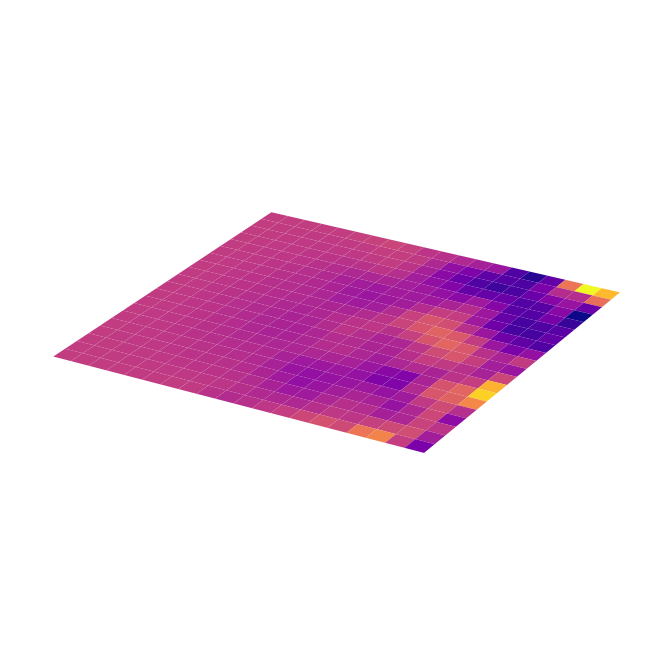

In [46]:
displacement = PlateBendingResults(mesh, vectors.transpose()[0])
displacement.Z_displacement_3D(scale=1)

## Convergence analysis

In [126]:
E = 2000000000.0 # N/mm^2
mu = 0.3
rho = 7.850 *(1 / 1000**3)  # kg/mm^3
steel = IsotropicMaterial( E, mu, rho)

results = []

for n in np.arange(5, 31, 1):

    nelx = n # elements in the x direction
    nely = n # elements in the y direction

    # Creating the mesh
    Lx = 200
    Ly = 200

    mesh = RectangleQuadMesh(Lx, Ly, nelx, nely)
    
    problem = FEM_Problem('modal', 'plate', mesh)

    t = 6  # mm

    problem.define_materials(steel)

    problem.define_tensors(t, 1)

    x = [0, Lx]
    y = [[0, Ly]]
    fixed_domain1 = create_domain(x, y)
    problem.add_fixed_domain(fixed_domain1, ddls=[2])

    x = [[0, Lx]]
    y = [0, Ly]
    fixed_domain2 = create_domain(x, y)
    problem.add_fixed_domain(fixed_domain2, ddls=[2])

    problem.assemble('K')
    problem.assemble('M')
    problem.fix_boundary()
    result = problem.solve()
    results.append(result)


In [146]:
frequencies = []

for result in results:

    omegas = result[0]

    freqs = np.array([np.sqrt(freq) for freq in omegas if freq > 0])
    freqs = freqs[freqs>=140]
    tol = 10  # Hz
    freqs = freqs[~(np.triu(np.abs(freqs[:,None] - freqs) <= tol,1)).any(0)]
    
    frequencies.append(freqs[:9])

#frequencies = np.array([frequencie[:5] for frequencie in frequencies])


frequencies = np.array(frequencies)


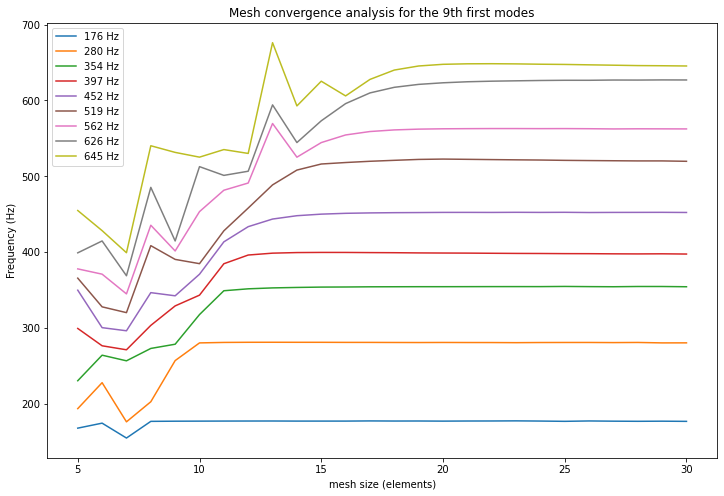

In [147]:
fig, ax = plt.subplots(figsize=(12,8))
mesh_sizes = np.arange(5, 31, 1)

for i, mode  in enumerate(frequencies.transpose()) :
    ax.plot(mesh_sizes, mode, label= str(int(mode[-1])) + ' Hz')
plt.legend()
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('mesh size (elements)')
ax.set_title('Mesh convergence analysis for the 9th first modes')
plt.show()